# NLP Shared Task 2021

## Proficiency Level Identification Notebook

Pauline Claes

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score, f1_score
from sklearn.compose import make_column_transformer
from sklearn.ensemble import StackingClassifier

import nltk
from nltk.tokenize import word_tokenize
nltk__word_tokenizer = word_tokenize
nltk.download("punkt")
import spacy
nlp = spacy.load("en_core_web_sm")
from spacy.lang.en import English
from nltk.corpus import stopwords
stop_words_list = set(stopwords.words("english"))


np.random.seed(1)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/paulineclaes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [92]:
df = pd.read_csv("train_preprocessed.csv")

In [93]:
df.head()

,Filename,text,Language,Proficiency,pos_tags,lemma_text,n_words,n_sentences,doc_length,stop_words
0,88.txt,Some people might think that traveling in a gr...,KOR,high,DT NNS MD VB IN VBG IN DT NN VBN IN DT NN NN V...,some people may think that travel in a group l...,384,16,1940,some that in a by a is a a has its and does no...
1,278.txt,IThe importance and popularity of travelling i...,DEU,medium,"IN NN CC NN IN VBG VBZ RB VBG , _SP NN VBZ JJ ...",ithe importance and popularity of travel be st...,321,13,1645,and of is is in to other and but the how to do...
2,348.txt,"It is an important decision, how to plan your ...",TUR,high,"PRP VBZ DT JJ NN , WRB TO VB PRP$ NN . DT NNS ...","-PRON- be an important decision , how to plan ...",360,15,2022,it is an how to your some to a of and their so...
3,666.txt,Some people believe that young people can enjo...,ZHO,medium,DT NNS VBP IN JJ NNS MD VB NN JJR IN JJR NN VB...,some people believe that young people can enjo...,347,26,1891,some that can more than from my of the is the ...
4,733.txt,Travelling is usually considered as good recr...,TEL,medium,"NNP VBZ _SP RB VBN IN JJ NN _SP IN JJ NNS , IN...",Travelling be usually consider as good recre...,349,13,1862,is as by as for and it is to have some and a w...


In [4]:
df.Proficiency.value_counts() # unbalanced

medium    5964
high      3835
low       1201
Name: Proficiency, dtype: int64

Text(0.5, 0, '(Target) Classes of Proficiency level')

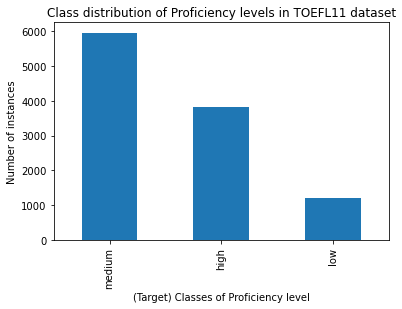

In [5]:
df['Proficiency'].value_counts().plot(kind = "bar")
plt.title("Class distribution of Proficiency levels in TOEFL11 dataset")
plt.ylabel("Number of instances")
plt.xlabel("(Target) Classes of Proficiency level")

In [56]:
X = df.text.values
y = df.Proficiency.values

In [57]:
X_train, X_dev, y_train, y_dev = train_test_split(X,
                                                  y, 
                                                  test_size=0.1,
                                                  random_state=1,
                                                  shuffle=True,
                                                  stratify=y)

# 1. Baselines

## 1.1. Dummy Classifier

In [8]:
from sklearn.dummy import DummyClassifier

### 1.1.1. Dummy Classifier with CountVectorizer

In [9]:
cvect = CountVectorizer()
dummy_clf = DummyClassifier(strategy="stratified", random_state=1)

In [10]:
base1 = make_pipeline(cvect, dummy_clf, verbose=True)

In [12]:
base1.fit(X_train, y_train)

[Pipeline] ... (step 1 of 2) Processing countvectorizer, total=   1.8s
[Pipeline] ... (step 2 of 2) Processing dummyclassifier, total=   0.0s


Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('dummyclassifier',
                 DummyClassifier(random_state=1, strategy='stratified'))],
         verbose=True)

In [13]:
y_pred_dummy = base1.predict(X_dev)

In [14]:
print(f1_score(y_dev, y_pred_dummy, average="macro"))

0.3259427657478984


In [15]:
print(classification_report(y_dev, y_pred_dummy))

              precision    recall  f1-score   support

        high       0.35      0.33      0.34       384
         low       0.07      0.08      0.08       120
      medium       0.57      0.56      0.56       596

    accuracy                           0.43      1100
   macro avg       0.33      0.32      0.33      1100
weighted avg       0.44      0.43      0.43      1100



### 1.1.2. Dummy Classifier with TfidfVectorizer

In [16]:
tfidf = TfidfVectorizer()
dummy_clf = DummyClassifier(strategy="stratified", random_state=1)

In [17]:
base2 = make_pipeline(tfidf, dummy_clf, verbose=True)

In [18]:
base2.fit(X_train, y_train)

[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=   1.8s
[Pipeline] ... (step 2 of 2) Processing dummyclassifier, total=   0.0s


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('dummyclassifier',
                 DummyClassifier(random_state=1, strategy='stratified'))],
         verbose=True)

In [19]:
y_pred_base_2 = base2.predict(X_dev)

In [20]:
print(f1_score(y_dev, y_pred_base_2, average="macro"))

0.3259427657478984


In [21]:
print(classification_report(y_dev, y_pred_base_2))

              precision    recall  f1-score   support

        high       0.35      0.33      0.34       384
         low       0.07      0.08      0.08       120
      medium       0.57      0.56      0.56       596

    accuracy                           0.43      1100
   macro avg       0.33      0.32      0.33      1100
weighted avg       0.44      0.43      0.43      1100



## 1.2. Support Vector Machine

### 1.2.1. SVM and CountVectorizer

In [27]:
cvect = CountVectorizer()
svm = SVC()

In [28]:
base3 = make_pipeline(cvect, svm)

In [29]:
base3.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()), ('svc', SVC())])

In [30]:
y_pred_base3 = base3.predict(X_dev)

In [31]:
print(f1_score(y_dev, y_pred_base3, average="macro"))

0.717869055926037


In [32]:
print(classification_report(y_dev, y_pred_base3))

              precision    recall  f1-score   support

        high       0.78      0.63      0.70       384
         low       0.80      0.57      0.67       120
      medium       0.73      0.86      0.79       596

    accuracy                           0.75      1100
   macro avg       0.77      0.69      0.72      1100
weighted avg       0.75      0.75      0.74      1100



### 1.2.2. SVM and TfidfVectorizer

In [33]:
tfidf = TfidfVectorizer()
svm = SVC()

In [34]:
base4 = make_pipeline(tfidf, svm, verbose=True)

In [35]:
base4.fit(X_train, y_train)

[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=   1.9s
[Pipeline] ............... (step 2 of 2) Processing svc, total= 2.2min


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()), ('svc', SVC())],
         verbose=True)

In [36]:
y_pred_base4 = base4.predict(X_dev)

In [37]:
print(f1_score(y_dev, y_pred_base4, average="macro"))

0.5898793061354849


In [38]:
print(classification_report(y_dev, y_pred_base4))

              precision    recall  f1-score   support

        high       0.76      0.65      0.70       384
         low       0.85      0.18      0.30       120
      medium       0.69      0.86      0.77       596

    accuracy                           0.71      1100
   macro avg       0.77      0.57      0.59      1100
weighted avg       0.73      0.71      0.69      1100



## 1.3. BERT
Please check separate notebook for BERT baseline for Proficiency Level Identification.

# 2. Pipeline models

## 2.1. Pipe1. CountVectorizer and LinearSVC

In [53]:
cvect = CountVectorizer(tokenizer = nltk__word_tokenizer,
                        ngram_range=(1,3))
linear_svc = LinearSVC(multi_class="ovr", 
                      class_weight="balanced",
                      random_state=1,
                      max_iter=5000)

In [54]:
pipe1 = make_pipeline(cvect, linear_svc, verbose=True)

In [58]:
pipe1.fit(X_train, y_train)

[Pipeline] ... (step 1 of 2) Processing countvectorizer, total=  33.5s
[Pipeline] ......... (step 2 of 2) Processing linearsvc, total=  12.9s


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function word_tokenize at 0x7fecec69eb80>)),
                ('linearsvc',
                 LinearSVC(class_weight='balanced', max_iter=5000,
                           random_state=1))],
         verbose=True)

In [59]:
y_pred_pipe1 = pipe1.predict(X_dev)

In [60]:
print(f1_score(y_dev, y_pred_pipe1, average="macro"))

0.665871432804802


In [61]:
print(classification_report(y_dev, y_pred_pipe1))

              precision    recall  f1-score   support

        high       0.72      0.66      0.69       384
         low       0.65      0.51      0.57       120
      medium       0.71      0.78      0.74       596

    accuracy                           0.71      1100
   macro avg       0.69      0.65      0.67      1100
weighted avg       0.71      0.71      0.70      1100



## 2.2. CountVectorizer and Logistic Regression

In [14]:
cvect = CountVectorizer(tokenizer = nltk__word_tokenizer,
                        ngram_range=(1,3))
logreg = LogisticRegression(multi_class="ovr",
                            class_weight="balanced", # uses value of y to automatically adjust weights inversely proportional to class frequencies
                            max_iter = 5000,
                            n_jobs = -1,
                            random_state=1)

In [15]:
pipe2 = make_pipeline(cvect, logreg, verbose=True)

In [16]:
pipe2.fit(X_train, y_train)

[Pipeline] ... (step 1 of 2) Processing countvectorizer, total=  32.8s
[Pipeline]  (step 2 of 2) Processing logisticregression, total= 6.6min


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function word_tokenize at 0x7fecec69eb80>)),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=5000,
                                    multi_class='ovr', n_jobs=-1,
                                    random_state=1))],
         verbose=True)

In [17]:
y_pred_pipe2 = pipe2.predict(X_dev)

In [18]:
print(f1_score(y_dev, y_pred_pipe2, average="macro"))

0.72212387761445


In [19]:
print(classification_report(y_dev, y_pred_pipe2))

              precision    recall  f1-score   support

        high       0.74      0.74      0.74       384
         low       0.67      0.65      0.66       120
      medium       0.76      0.77      0.77       596

    accuracy                           0.75      1100
   macro avg       0.72      0.72      0.72      1100
weighted avg       0.75      0.75      0.75      1100



## 2.3. CountVectorizer and SGDClassifier

In [20]:
cvect = CountVectorizer(tokenizer = nltk__word_tokenizer,
                        ngram_range=(1,3))
sgd = SGDClassifier(loss="log", 
                   max_iter=5000, 
                   n_jobs=-1,
                   class_weight="balanced",
                   random_state=1)

In [21]:
pipe3 = make_pipeline(cvect, sgd, verbose=True)

In [22]:
pipe3.fit(X_train, y_train)

[Pipeline] ... (step 1 of 2) Processing countvectorizer, total=  32.8s
[Pipeline] ..... (step 2 of 2) Processing sgdclassifier, total=   3.3s


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function word_tokenize at 0x7fecec69eb80>)),
                ('sgdclassifier',
                 SGDClassifier(class_weight='balanced', loss='log',
                               max_iter=5000, n_jobs=-1, random_state=1))],
         verbose=True)

In [23]:
y_pred_pipe3 = pipe3.predict(X_dev)

In [24]:
print(f1_score(y_dev, y_pred_pipe3, average="macro"))

0.6092957081788654


In [25]:
print(classification_report(y_dev, y_pred_pipe3))

              precision    recall  f1-score   support

        high       0.69      0.67      0.68       384
         low       0.62      0.32      0.42       120
      medium       0.69      0.77      0.73       596

    accuracy                           0.69      1100
   macro avg       0.67      0.59      0.61      1100
weighted avg       0.68      0.69      0.68      1100



# 3. Combining features

In [96]:
train, dev = train_test_split(df, 
                             test_size=0.1,
                             random_state=1,
                             shuffle=True,
                             stratify = df.Proficiency)

In [97]:
train.Proficiency.value_counts()

medium    5368
high      3451
low       1081
Name: Proficiency, dtype: int64

In [98]:
dev.Proficiency.value_counts()

medium    596
high      384
low       120
Name: Proficiency, dtype: int64

In [114]:
train.head()

,Filename,text,Language,Proficiency,pos_tags,lemma_text,n_words,n_sentences,doc_length,stop_words
9134,1664392.txt,I am in complete agreement of the statement th...,HIN,high,PRP VBP IN JJ NN IN DT NN IN PRP$ RBR JJ IN NN...,-PRON- be in complete agreement of the stateme...,306,15,1783,i am in of the that its more for to and than i...
2382,434670.txt,Of course I agree to the statement that we hav...,KOR,medium,RB RB PRP VBP IN DT NN IN PRP VBP TO VB RB JJ ...,of course -PRON- agree to the statement that -...,319,15,1756,of i to the that we have to be of the are each...
8011,1450658.txt,During my study I learned a lot about advertis...,DEU,medium,IN PRP$ NN PRP VBD DT NN IN NNS . PRP$ NN RB V...,during -PRON- study -PRON- learn a lot about a...,315,13,1784,during my i a about our that should to a but n...
345,63277.txt,I agree the opinion that most advertisements m...,KOR,medium,PRP VBP DT NN IN JJS NNS VBP NNS VB RBR IN PRP...,-PRON- agree the opinion that most advertiseme...,237,16,1439,i the that most than they now we in the in the...
2045,372234.txt,There are some advantages in beeing versed reg...,DEU,medium,EX VBP DT NNS IN NN VBD VBG DT JJ NN RB RB IN ...,there be some advantage in beeing verse regard...,339,19,1911,there are some in a as as having about a of it...


## 3.1. Combo 1. (LogisticRegression). Token *n*-grams (1,3), number of words

In [31]:
X_train = train[["text", "n_words"]]
y_train = train['Proficiency']

X_dev = dev[["text", "n_words"]]
y_dev = dev['Proficiency']

In [33]:
cvect_tokens = CountVectorizer(tokenizer=nltk__word_tokenizer, ngram_range=(1,3))

sc = StandardScaler(with_mean=False) # mean=False to allow to work with sparse vector

preprocessor = make_column_transformer(
    (sc, ["n_words"]),
    (cvect_tokens, "text"), 
    remainder="passthrough"
)

logreg = LogisticRegression(multi_class="ovr",
                            class_weight="balanced", # uses value of y to automatically adjust weights inversely proportional to class frequencies
                            max_iter = 5000,
                            n_jobs = -1,
                            random_state=1)

In [34]:
combo1 = make_pipeline(preprocessor, logreg, verbose=True)

In [35]:
combo1.fit(X_train, y_train)

[Pipeline] . (step 1 of 2) Processing columntransformer, total=  33.8s
[Pipeline]  (step 2 of 2) Processing logisticregression, total= 7.6min


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(with_mean=False),
                                                  ['n_words']),
                                                 ('countvectorizer',
                                                  CountVectorizer(ngram_range=(1,
                                                                               3),
                                                                  tokenizer=<function word_tokenize at 0x7fecec69eb80>),
                                                  'text')])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=5000,
                                    multi_class='ovr', n_jobs=-1,
                                    random_state=1))],
         verbose=True)

In [36]:
y_pred_combo1 = combo1.predict(X_dev)

In [37]:
print(f1_score(y_dev, y_pred_combo1, average="macro"))

0.7234926290317469


In [38]:
print(classification_report(y_dev, y_pred_combo1))

              precision    recall  f1-score   support

        high       0.74      0.74      0.74       384
         low       0.67      0.65      0.66       120
      medium       0.76      0.77      0.77       596

    accuracy                           0.75      1100
   macro avg       0.73      0.72      0.72      1100
weighted avg       0.75      0.75      0.75      1100



## 3.2. Combo 2. (LogisticRegression). Lemma *n*-grams (1,3), number of words

In [41]:
X_train = train[["lemma_text", "n_words"]]
y_train = train['Proficiency']

X_dev = dev[["lemma_text", "n_words"]]
y_dev = dev['Proficiency']

In [45]:
cvect_tokens = CountVectorizer(tokenizer=nltk__word_tokenizer, ngram_range=(1,3))

sc = StandardScaler(with_mean=False) # mean=False to allow to work with sparse vector

preprocessor2 = make_column_transformer(
    (sc, ["n_words"]),
    (cvect_tokens, "lemma_text"), 
    remainder="passthrough"
)

logreg2 = LogisticRegression(multi_class="ovr",
                            class_weight="balanced", # uses value of y to automatically adjust weights inversely proportional to class frequencies
                            max_iter = 5000,
                            n_jobs = -1,
                            random_state=1)

In [46]:
combo2 = make_pipeline(preprocessor2, logreg2, verbose=True)

In [47]:
combo2.fit(X_train, y_train)

[Pipeline] . (step 1 of 2) Processing columntransformer, total=  30.7s
[Pipeline]  (step 2 of 2) Processing logisticregression, total= 7.7min


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(with_mean=False),
                                                  ['n_words']),
                                                 ('countvectorizer',
                                                  CountVectorizer(ngram_range=(1,
                                                                               3),
                                                                  tokenizer=<function word_tokenize at 0x7fecec69eb80>),
                                                  'lemma_text')])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=5000,
                                    multi_class='ovr', n_jobs=-1,
                                    random_state=1))],
         verbose=True)

In [50]:
y_pred_combo2 = combo2.predict(X_dev)

In [51]:
print(f1_score(y_dev, y_pred_combo2, average="macro"))

0.7080966071986734


In [52]:
print(classification_report(y_dev, y_pred_combo1))

              precision    recall  f1-score   support

        high       0.74      0.74      0.74       384
         low       0.67      0.65      0.66       120
      medium       0.76      0.77      0.77       596

    accuracy                           0.75      1100
   macro avg       0.73      0.72      0.72      1100
weighted avg       0.75      0.75      0.75      1100



## 3.3. Combo 3. (LogisticRegression). Token *n*-grams, number of tokens, pos_tags <u>(BEST PERFORMING CLASSIFIER)</u>

In [121]:
from statistics import mean

In [122]:
level_dict = {}
for level in train.Proficiency.unique(): 
    print(level)
    level_dict[level] = mean(train[train["Proficiency"]==level]["n_words"])
    
level_dict

high
medium
low


{'high': 363.2454361054767,
 'medium': 306.26657973174366,
 'low': 206.29232192414432}

In [99]:
X_train = train[["text", "n_words", "pos_tags"]]
y_train = train['Proficiency']

X_dev = dev[["text", "n_words", "pos_tags"]]
y_dev = dev['Proficiency']

In [100]:
cvect_tokens = CountVectorizer(tokenizer=nltk__word_tokenizer, 
                               ngram_range=(1,3))

cvect_pos = CountVectorizer(max_features = 1000,
                           ngram_range=(1,3))

sc = StandardScaler(with_mean=False) # mean=False to allow to work with sparse vector

preprocessor3 = make_column_transformer(
    (sc, ["n_words"]),
    (cvect_tokens, "text"), 
    (cvect_pos, "pos_tags"),
    remainder="passthrough"
)

logreg3 = LogisticRegression(multi_class="ovr",
                            class_weight="balanced", # uses value of y to automatically adjust weights inversely proportional to class frequencies
                            max_iter = 5000,
                            n_jobs = -1,
                            random_state=1)

In [105]:
combo3 = make_pipeline(preprocessor3, logreg3, verbose=True)

In [106]:
combo3.fit(X_train, y_train)

[Pipeline] . (step 1 of 2) Processing columntransformer, total=  40.0s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=20.1min


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(with_mean=False),
                                                  ['n_words']),
                                                 ('countvectorizer-1',
                                                  CountVectorizer(ngram_range=(1,
                                                                               3),
                                                                  tokenizer=<function word_tokenize at 0x7fecec69eb80>),
                                                  'text'),
                                                 ('countvectorizer-2',
                                                  CountVectorizer(max_features=1000,
                                                                  ngram_range=(1,
                                 

In [110]:
y_pred_combo3 = combo3.predict(X_dev)

In [111]:
print(f1_score(y_dev, y_pred_combo3, average="macro"))

0.7323710965912943


In [112]:
print(classification_report(y_dev, y_pred_combo3))

              precision    recall  f1-score   support

        high       0.75      0.74      0.75       384
         low       0.68      0.67      0.68       120
      medium       0.77      0.78      0.78       596

    accuracy                           0.75      1100
   macro avg       0.73      0.73      0.73      1100
weighted avg       0.75      0.75      0.75      1100



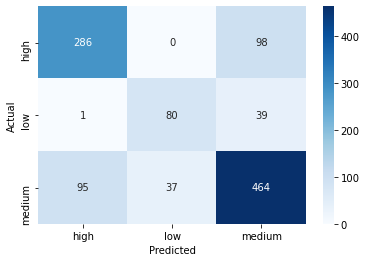

In [113]:
confusion_matrix = pd.crosstab(y_dev, y_pred_combo3, rownames=['Actual'], colnames=['Predicted']) 
sn.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.show()

## 3.4. Combo 4. (LogisticRegression). Token *n*-grams (1,3), number of tokens, POS-tags, function words

In [71]:
X_train = train[["text", "n_words", "pos_tags", "stop_words"]]
y_train = train['Proficiency']

X_dev = dev[["text", "n_words", "pos_tags", "stop_words"]]
y_dev = dev['Proficiency']

In [73]:
cvect_tokens = CountVectorizer(tokenizer=nltk__word_tokenizer, 
                               ngram_range=(1,3))

cvect_pos = CountVectorizer(max_features = 1000,
                           ngram_range=(1,3))

sc = StandardScaler(with_mean=False) # mean=False to allow to work with sparse vector

preprocessor4 = make_column_transformer(
    (sc, ["n_words"]),
    (cvect_tokens, "text"),
    (cvect_tokens, "stop_words"),
    (cvect_pos, "pos_tags"),
    remainder="passthrough"
)

logreg4 = LogisticRegression(multi_class="ovr",
                            class_weight="balanced", # uses value of y to automatically adjust weights inversely proportional to class frequencies
                            max_iter = 5000,
                            n_jobs = -1,
                            random_state=1)

In [74]:
combo4 = make_pipeline(preprocessor4, logreg4, verbose=True)

In [75]:
combo4.fit(X_train, y_train)

[Pipeline] . (step 1 of 2) Processing columntransformer, total=  45.3s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=21.3min


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(with_mean=False),
                                                  ['n_words']),
                                                 ('countvectorizer-1',
                                                  CountVectorizer(ngram_range=(1,
                                                                               3),
                                                                  tokenizer=<function word_tokenize at 0x7fecec69eb80>),
                                                  'text'),
                                                 ('countvectorizer-2',
                                                  CountVectorizer(ngram_range=(1,
                                                                               3),
                                   

In [76]:
y_pred_combo4 = combo4.predict(X_dev)

In [77]:
print(f1_score(y_dev, y_pred_combo4, average="macro"))

0.7317773391885026


In [78]:
print(classification_report(y_dev, y_pred_combo4))

              precision    recall  f1-score   support

        high       0.75      0.74      0.75       384
         low       0.66      0.68      0.67       120
      medium       0.78      0.78      0.78       596

    accuracy                           0.76      1100
   macro avg       0.73      0.73      0.73      1100
weighted avg       0.76      0.76      0.76      1100

